# source: https://github.com/victorgau/kchart

In [1]:
import pandas_datareader.data as web
from datetime import datetime

In [27]:
import os
import sys
import datetime
import numpy as np
import pandas as pd

# MatPlotLib 的主要模組
import matplotlib.pyplot as plt

# 畫圖形週邊東西的套件
from matplotlib import gridspec
from matplotlib.ticker import  FuncFormatter

import bisect

# 畫圖用的套件
from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.colors import colorConverter
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib import colors as mcolors

class Cursor(object):
    def __init__(self, ax):
        self.ax = ax
        self.lx = ax.axhline(color='lightgray')  # the horiz line
        self.ly = ax.axvline(color='lightgray')  # the vert line

    def mouse_move(self, event):
        if not event.inaxes:
            return

        x, y = event.xdata, event.ydata
        # update the line positions
        self.lx.set_ydata(y)
        self.ly.set_xdata(x)

        plt.draw()

class KChart:
    _param = {
        "show_title": False,
        "show_label": False,
        "show_grid": False,
        "is_draw_price_ta": True,
        "show_last_price": False,     # display price info. on the right-top
        "show_axis": False,
    }
    
    def get_param(cls, n):
        if n in cls._defaults:
            return cls._param[n]
        else:
            return "Unrecognized attribute name '" + n + "'"
    
    def __init__(self):
        pass
    
    def candlestick(self, ax, opens, highs, lows, closes, width=4, colorup='g', colordown='r', alpha=0.75, ):
        "畫 K 線圖"

        delta = width / 2.

        # 中間的 Box
        barVerts = [((i - delta, open),
                     (i - delta, close),
                     (i + delta, close),
                     (i + delta, open))
                    for i, open, close in zip(range(len(opens)), opens, closes)]

        # 下影線
        downSegments = [((i, low), (i, min(open, close)))
                         for i, low, high, open, close in zip(range(len(lows)), lows, highs, opens, closes)]

        # 上影線
        upSegments = [((i, max(open, close)), (i, high))
                         for i, low, high, open, close in zip(range(len(lows)), lows, highs, opens, closes)]

        rangeSegments = upSegments + downSegments

        r, g, b = colorConverter.to_rgb(colorup)
        colorup = r, g, b, alpha
        r, g, b = colorConverter.to_rgb(colordown)
        colordown = r, g, b, alpha
        colord = {True: colorup,
                  False: colordown,
                  }
        colors = [colord[open < close] for open, close in zip(opens, closes)]

        useAA = 0,  # use tuple here
        lw = 0.5,   # and here
        rangeCollection = LineCollection(rangeSegments,
                                         colors=((0, 0, 0, 1), ),
                                         linewidths=lw,
                                         antialiaseds=useAA,
                                         )

        barCollection = PolyCollection(barVerts,
                                       facecolors=colors,
                                       edgecolors=((0, 0, 0, 1), ),
                                       antialiaseds=useAA,
                                       linewidths=lw,
                                       )

        minx, maxx = 0, len(rangeSegments) / 2
        miny = min([low for low in lows])
        maxy = max([high for high in highs])

        corners = (minx, miny), (maxx, maxy)
        ax.update_datalim(corners)
        ax.autoscale_view()

        # add these last
        ax.add_collection(rangeCollection)
        ax.add_collection(barCollection)

        return rangeCollection, barCollection
    
    def volume_overlay(self, ax, opens, closes, volumes, colorup='g', colordown='r', width=4, alpha=1.0):
        """Add a volume overlay to the current axes.  The opens and closes
        are used to determine the color of the bar.  -1 is missing.  If a
        value is missing on one it must be missing on all

        Parameters
        ----------
        ax : `Axes`
            an Axes instance to plot to
        opens : sequence
            a sequence of opens
        closes : sequence
            a sequence of closes
        volumes : sequence
            a sequence of volumes
        width : int
            the bar width in points
        colorup : color
            the color of the lines where close >= open
        colordown : color
            the color of the lines where close <  open
        alpha : float
            bar transparency

        Returns
        -------
        ret : `barCollection`
            The `barrCollection` added to the axes

        """

        colorup = mcolors.to_rgba(colorup, alpha)
        colordown = mcolors.to_rgba(colordown, alpha)
        colord = {True: colorup, False: colordown}
        colors = [colord[open < close]
                  for open, close in zip(opens, closes)
                  if open != -1 and close != -1]

        delta = width / 2.
        bars = [((i - delta, 0), (i - delta, v), (i + delta, v), (i + delta, 0))
                for i, v in enumerate(volumes)
                if v != -1]

        barCollection = PolyCollection(bars,
                                       facecolors=colors,
                                       edgecolors=((0, 0, 0, 1), ),
                                       antialiaseds=(0,),
                                       linewidths=(0.5,),
                                       )

        ax.add_collection(barCollection)
        corners = (0, 0), (len(bars), max(volumes))
        ax.update_datalim(corners)
        ax.autoscale_view()

        # add these last
        return barCollection
    
    def millions(self, x, pos):
        'The two args are the value and tick position'
        return '%1.1fM' % (x*1e-6)


    def thousands(self, x, pos):
        'The two args are the value and tick position'
        return '%1.1fK' % (x*1e-3)


    def getListOfDates(self, startdate, enddate):
        "取得資料裡面的月份的第一天"
        dates = [datetime.date(m//12, m%12+1, 1) for m in range(startdate.year*12+startdate.month-1, enddate.year*12+enddate.month)]
        return np.array(dates)


    def getDateIndex(self, dates, tickdates):
        "找出最接近 tickdate 的日期的 index"
        index = [bisect.bisect_left(dates, tickdate) for tickdate in tickdates]
        return np.array(index)
    
    def getMonthNames(self, dates, index):
        "取得 X 軸上面日期的表示方式"
        names = []
        for i in index:
            if i==0:
                if dates[i].day > 15:
                    names.append("")
                else:
                    names.append(dates[i].strftime("%b'%y"))
            else:
                names.append(dates[i].strftime("%b'%y"))

        return np.array(names)

    def draw_price_ta(self, ax0, df):
        df['ma05'] = pd.Series.rolling(df['Close'], window=5).mean()
        df['ma20'] = pd.Series.rolling(df['Close'], window=20).mean()
        df['ma60'] = pd.Series.rolling(df['Close'], window=60).mean()
        ax0.plot(df['ma05'].values, color='m', lw=2, label='MA (5)')
        ax0.plot(df['ma20'].values, color='blue', lw=2, label='MA (20)')
        ax0.plot(df['ma60'].values, color='black', lw=2, label='MA (60)')


    def draw_volume_ta(self, ax1, df):
        pass
    
    def draw(self, df, fig_filename="", colorup='g', colordown='r'):
        # 畫出價量曲線

        # 檢查實際讀到的日期
        if not 'Date' in df.columns:
            df['Date'] = df.index.date

        startdate = df.index.date[0]
        enddate = df.index.date[-1]

        def format_coord1(x, y):
            "用來顯示股價相關資訊"
            try:
                index = int(x+0.5)
                if index < 0 or index >= len(df.Date):
                    return ""
                else:
                    return 'x=%s, y=%1.1f, price=%1.1f' % (df.Date[int(x+0.5)], y, df.Close[int(x+0.5)])
            except Exception as e:
                print(e.args)
                return ''


        def format_coord2(x, y):
            "用來顯示 Volume 的相關資訊"
            try:
                index = int(x+0.5)
                if index < 0 or index >= len(df.Date):
                    return ""
                else:
                    return 'x=%s, y=%1.1fM, volume=%1.1fM' % (df.Date[int(x+0.5)], y*1e-6, df.Volume[int(x+0.5)]*1e-6)
            except Exception as e:
                print(e.args)
                return ''

        # 如果沒有讀到任何股價，就跳出程式
        if df.empty:
            raise SystemExit

        tickdates = self.getListOfDates(startdate, enddate)
        tickindex = self.getDateIndex(df.Date, tickdates)
        ticknames = self.getMonthNames(df.Date, tickindex)

        millionformatter = FuncFormatter(self.millions)
        thousandformatter = FuncFormatter(self.thousands)

        fig = plt.figure(figsize=(16, 12))
        fig.subplots_adjust(bottom=0.1)
        fig.subplots_adjust(hspace=0)

        gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])

        ax0 = plt.subplot(gs[0])
        candles = self.candlestick(ax0, df.Open, df.High, df.Low, df.Close, width=1, colorup=colorup, colordown=colordown)

        if (KChart._param["show_last_price"]):
            last_price = "Date:{}, Open:{}, High:{}, Low:{}, Close:{}, Volume:{}".format(df.Date[-1], df.Open[-1], df.High[-1], df.Low[-1], df.Close[-1], df.Volume[-1])
            ax0.text(0.99, 0.97, last_price, horizontalalignment='right', verticalalignment='bottom', transform=ax0.transAxes)

        if (KChart._param["is_draw_price_ta"]):
            self.draw_price_ta(ax0, df)

        if (True):
            ax0.set_xticks(tickindex)
            ax0.set_xticklabels(ticknames)
            ax0.format_coord=format_coord1
        if (KChart._param["show_label"]):
            ax0.legend(loc='upper left', shadow=True, fancybox=True)
            ax0.set_ylabel('Price($)', fontsize=16)
        if (KChart._param["show_title"]):
            if False: #has_chinese_font:
                ax0.set_title(title, fontsize=24, fontweight='bold', fontproperties=font)
            else:
                ax0.set_title(title, fontsize=24, fontweight='bold')
        if (KChart._param["show_grid"]):
            ax0.grid(True)

        ax1 = plt.subplot(gs[1], sharex=ax0)
        vc = self.volume_overlay(ax1, df.Open, df.Close, df.Volume, colorup=colorup, colordown=colordown, width=1)

        if (True):
            ax1.set_xticks(tickindex)
            ax1.set_xticklabels(ticknames)
            ax1.format_coord=format_coord2

        if (True):
            ax1.tick_params(axis='x',direction='out',length=5)
            ax1.yaxis.set_major_formatter(millionformatter)
            ax1.yaxis.tick_right()
        if (KChart._param["show_label"]):
            ax1.yaxis.set_label_position("right")
            ax1.set_ylabel('Volume', fontsize=16)
        if (KChart._param["show_grid"]):
            ax1.grid(True)

        plt.setp(ax0.get_xticklabels(), visible=False)
        
        if (KChart._param["show_axis"] == False):
            ax0.yaxis.set_visible(False)
            ax1.xaxis.set_visible(False)
            ax1.yaxis.set_visible(False)

        '''
        cursor0 = Cursor(ax0)
        cursor1 = Cursor(ax1)
        plt.connect('motion_notify_event', cursor0.mouse_move)
        plt.connect('motion_notify_event', cursor1.mouse_move)

        # 使用 cursor 的時候，如果沒有設定上下限，圖形的上下限會跑掉
        yh = df.High.max()
        yl = df.Low.min()
        ax0.set_ylim(yl - (yh-yl)/20.0, yh + (yh-yl)/20.0)
        ax0.set_xlim(0, len(df.Date)-1)
        '''

        if (len(fig_filename) > 0):
            plt.savefig(fig_filename)
        else:
            plt.show()

In [3]:
df = web.DataReader('GOOG', 'yahoo', datetime(2017, 1, 1))

In [11]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,Date,ma05,ma20,ma60
Date,,,,,,,,,,
2017-01-03,789.630005,775.799988,778.809998,786.140015,1657300,786.140015,2017-01-03,NaN,NaN,NaN
2017-01-04,791.340027,783.159973,788.359985,786.900024,1073000,786.900024,2017-01-04,NaN,NaN,NaN
2017-01-05,794.479980,785.020020,786.080017,794.020020,1335200,794.020020,2017-01-05,NaN,NaN,NaN
2017-01-06,807.900024,792.203979,795.260010,806.150024,1640200,806.150024,2017-01-06,NaN,NaN,NaN
2017-01-09,809.966003,802.830017,806.400024,806.650024,1272400,806.650024,2017-01-09,795.972021,NaN,NaN


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:214: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

fig_filename:


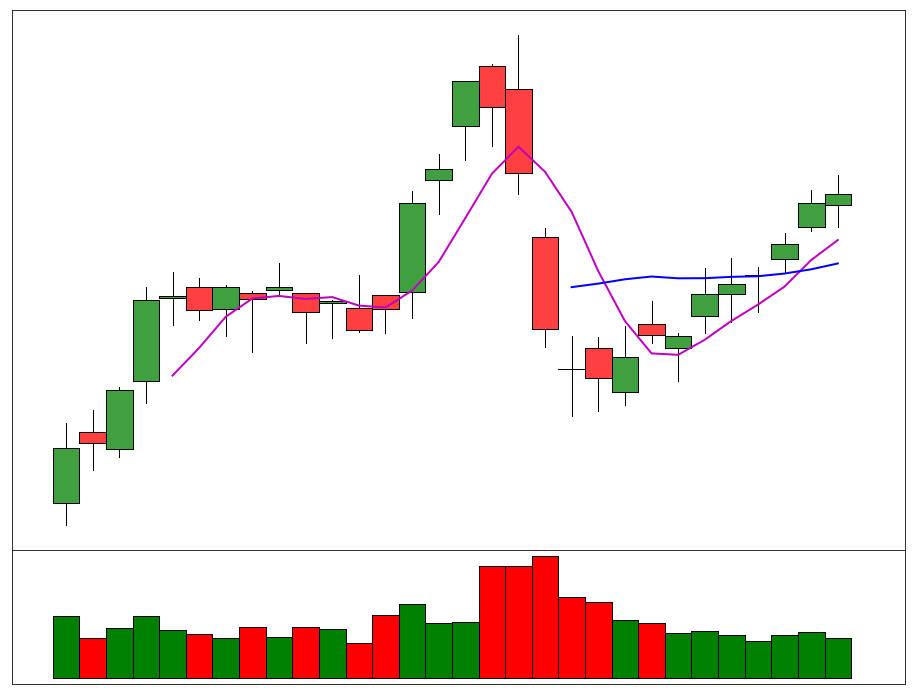

In [28]:
my_kchart = KChart()
my_kchart.draw(df[:30])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:214: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

fig_filename:kchart.png


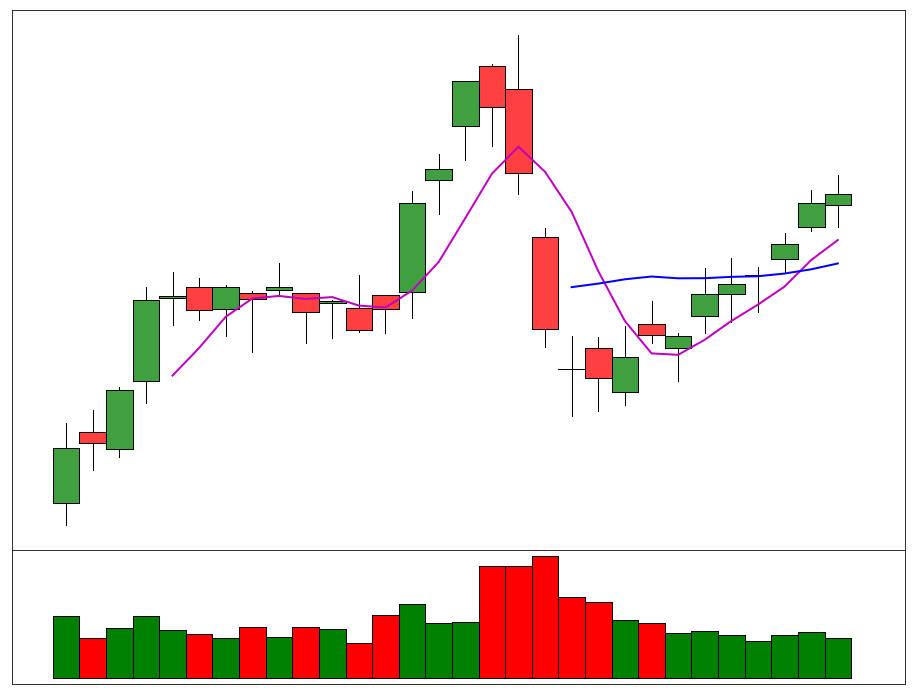

In [26]:
my_kchart.draw(df[:30], "kchart.png")